In [1]:
import copy

import numpy as np
import sympy as smp
import matplotlib.pyplot as plt

from centrex_tlf import states, couplings, transitions, hamiltonian, lindblad

from effective_hamiltonian import build_effective_operators
from julia_code import sympy_matrix_to_julia_fill_hermitian

In [2]:
plt.rcParams.update({f"font.size": 14})

In [3]:
X_states_uncoupled = states.generate_uncoupled_states_ground(Js=[0, 1, 2])

ham_uncoupled = hamiltonian.generate_uncoupled_hamiltonian_X(X_states_uncoupled)
ham_func = hamiltonian.generate_uncoupled_hamiltonian_X_function(ham_uncoupled)

In [4]:
Huncoupled = ham_func([0, 0, 0], [0, 0, 1e-5])
eigenvals, eigenvecs = np.linalg.eigh(Huncoupled)
H0 = np.diag(eigenvals)
HSz_unc = ham_uncoupled.HSz * 2 * np.pi

# filter small values
m = np.abs(HSz_unc) < (np.abs(HSz_unc).max() / 1e6)
HSz_unc[m] = 0

# make states and filter
QN = hamiltonian.matrix_to_states(eigenvecs, list(X_states_uncoupled))
QN = [qn.remove_small_components().normalize() for qn in QN]

# Microwave couplings

In [5]:
QN_coupled = [qn.transform_to_coupled() for qn in QN]
QN_coupled = [qn.remove_small_components().normalize() for qn in QN_coupled]

In [6]:
X_states_coupled = [qn.transform_to_coupled() for qn in X_states_uncoupled]
full_dmat = couplings.generate_coupling_matrix(
    X_states_coupled,
    X_states_coupled[:4],
    X_states_coupled[4:16],
    np.array([0, 0, 1], dtype=np.complex128),
)

In [7]:
from centrex_tlf.couplings.transition import TransitionSelector


trans = [
    transitions.MicrowaveTransition(0, 1),
]

transition_selectors: list[TransitionSelector] = (
    couplings.generate_transition_selectors(
        transitions=trans,
        polarizations=[
            [couplings.polarization_Z],
        ],
    )
)

QN_coupled_largest = [qn.largest for qn in QN_coupled]
coupling_fields = []
for trans in transition_selectors:
    ground_states = [
        QN_coupled[idx]
        for idx in np.unique(
            [QN_coupled_largest.index(qn.largest) for qn in trans.ground]
        )
    ]
    excited_states = [
        QN_coupled[idx]
        for idx in np.unique(
            [QN_coupled_largest.index(qn.largest) for qn in trans.excited]
        )
    ]

    cf = []
    for pol in trans.polarizations:
        cmat = couplings.generate_coupling_matrix(
            QN_coupled, ground_states, excited_states, pol
        )
        # filter small values
        cmat[np.abs(cmat) < (np.abs(cmat).max() / 1e4)] = 0
        cf.append(couplings.CouplingField(pol, cmat))

    main_coupling = np.abs(cf[0].field).max()
    idg, ide = np.where(np.abs(cf[0].field) == main_coupling)[0]
    coupling_fields.append(
        couplings.CouplingFields(
            QN_coupled[idg],
            QN_coupled[ide],
            main_coupling,
            ground_states,
            excited_states,
            cf,
        )
    )


In [8]:
cpl_free = coupling_fields[0].fields[0].field

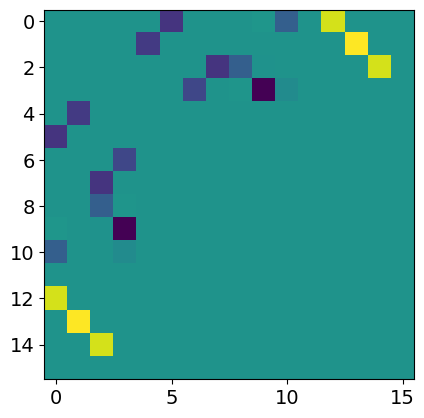

In [9]:
plt.imshow(cpl_free.real[:16, :16])

In [10]:
np.allclose(
    np.abs((eigenvecs.conj().T @ full_dmat @ eigenvecs))[:16, :16],
    np.abs(cpl_free)[:16, :16],
    atol=1e-3,
    rtol=1e-7,
)

True

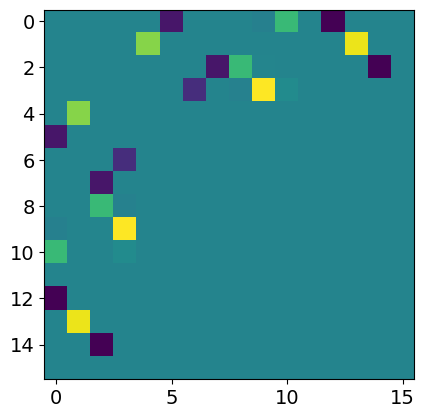

In [11]:
plt.imshow((eigenvecs.conj().T @ full_dmat @ eigenvecs).real[:16, :16])

In [12]:
full_dmat_free = eigenvecs.conj().T @ full_dmat @ eigenvecs
# Effective Hamiltonian
Heff0, Heff1, Heff2, Hmw0, Hmw1 = build_effective_operators(
    eigenvals, eigenvecs, HSz_unc, full_dmat_free, blocks=[(0, 16)]
)

In [13]:
np.allclose(H0[:16, :16], Heff0)

True

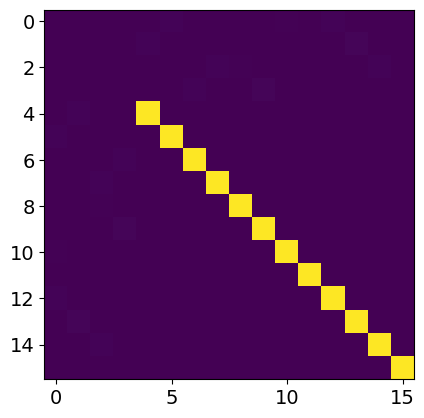

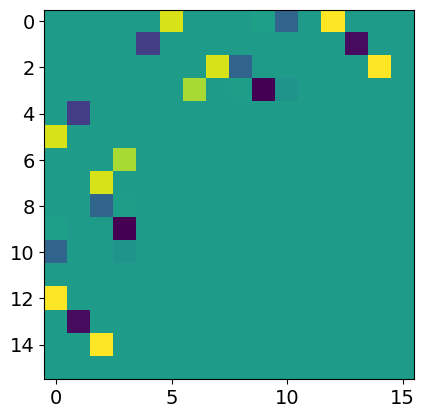

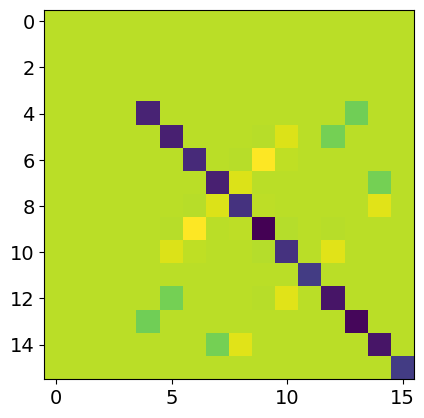

In [14]:
plt.imshow(np.abs(Heff0 + 172 * Heff1 + 172**2 * Heff2))
plt.figure()
plt.imshow(np.real(172 * Heff1))
plt.figure()
plt.imshow(np.real(172**2 * Heff2))

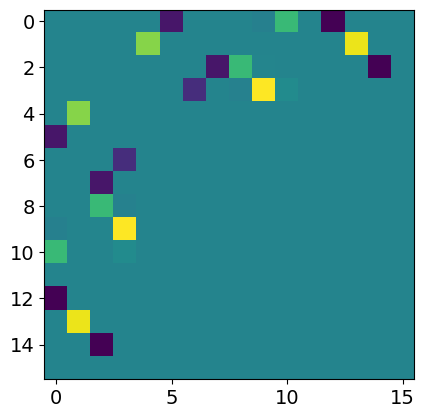

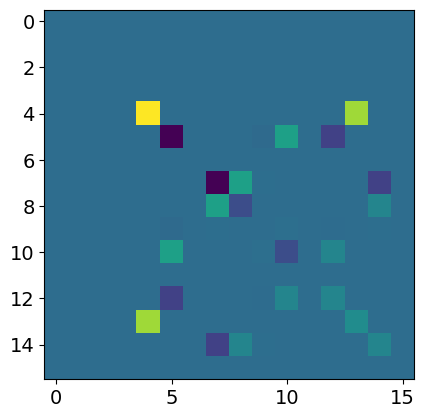

In [15]:
plt.imshow(Hmw0.real)
plt.figure()
plt.imshow(172 * Hmw1.real)

In [16]:
# basically Hmw1 is very small so doesn't contribute much
max_offdiag = np.max(np.abs(Hmw1 - np.diag(np.diag(Hmw1))))
max_diag = np.max(np.abs(np.diag(Hmw1)))
ratio = max(max_offdiag, max_diag) / np.max(np.abs(Hmw0))
print(f"{ratio=:.2e}")

ratio=3.12e-12


In [17]:
Heff = Heff0 + 172 * Heff1  # + 172**2 * Heff2
E_eff, U_eff = np.linalg.eigh(Heff)

In [18]:
blocks = [(0, 4), (4, 16)]
keep = np.hstack([np.arange(s, t) for s, t in blocks])  # [0,1,…,15]
n = eigenvecs.shape[0]
m = len(keep)
Psi_fieldfree = np.zeros((n, m), complex)
# each column j of U_P gives the P-space coefficients of eigenvector j
# so stick them into the rows of Psi_fieldfree labelled by 'keep'
Psi_fieldfree[keep, :] = U_eff
Psi_uncoupled_eff = eigenvecs @ Psi_fieldfree

QN172eff = hamiltonian.matrix_to_states(Psi_uncoupled_eff, list(X_states_uncoupled))
QN172eff[7]

1.00+0.00j x |J = 1, mJ = -1, I₁ = 1/2, m₁ = 1/2, I₂ = 1/2, m₂ = -1/2, P = -, Ω = 0>
0.07+0.00j x |J = 1, mJ = -1, I₁ = 1/2, m₁ = -1/2, I₂ = 1/2, m₂ = 1/2, P = -, Ω = 0>
-0.03+0.00j x |J = 1, mJ = 0, I₁ = 1/2, m₁ = -1/2, I₂ = 1/2, m₂ = -1/2, P = -, Ω = 0>

In [19]:
E172, U172 = np.linalg.eigh(ham_func([0, 0, 172], [0, 0, 1e-5]))
QN172 = hamiltonian.matrix_to_states(U172, list(X_states_uncoupled))
QN172[7]

1.00-0.00j x |J = 1, mJ = -1, I₁ = 1/2, m₁ = 1/2, I₂ = 1/2, m₂ = -1/2, P = -, Ω = 0>
0.07-0.00j x |J = 1, mJ = -1, I₁ = 1/2, m₁ = -1/2, I₂ = 1/2, m₂ = 1/2, P = -, Ω = 0>
-0.03+0.00j x |J = 1, mJ = 0, I₁ = 1/2, m₁ = -1/2, I₂ = 1/2, m₂ = -1/2, P = -, Ω = 0>
0.01-0.00j x |J = 2, mJ = -1, I₁ = 1/2, m₁ = 1/2, I₂ = 1/2, m₂ = -1/2, P = +, Ω = 0>

In [20]:
(E172[:16] - E_eff) / (2 * np.pi * 1e3)

array([-2.24323676e-01, -2.24323677e-01, -2.24323605e-01, -2.24323669e-01,
       -1.00529974e+03, -1.00543460e+03, -1.00537965e+03, -1.00537965e+03,
       -1.00511817e+03, -1.00511817e+03, -1.00511632e+03, -1.00511632e+03,
       -1.33970468e+03, -1.33970468e+03, -1.33965190e+03, -1.33978658e+03])

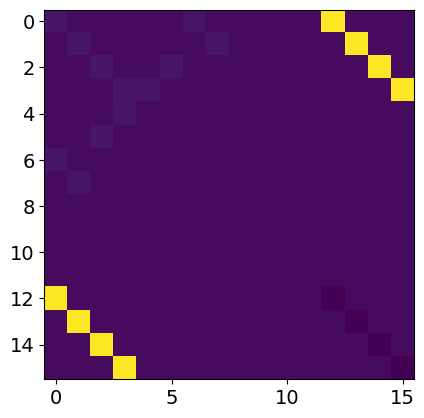

In [21]:
plt.imshow((U_eff.conj().T @ (Hmw0) @ U_eff).real)

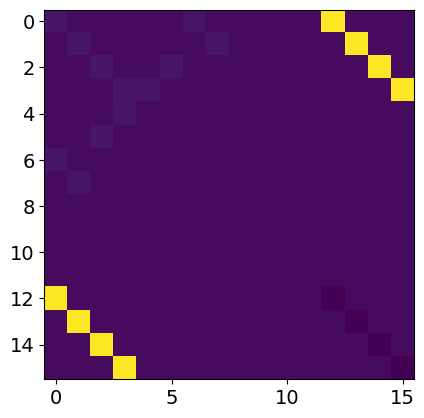

In [22]:
plt.imshow(
    (
        U_eff.conj().T @ (eigenvecs.conj().T @ full_dmat @ eigenvecs)[:16, :16] @ U_eff
    ).real
)

In [23]:
QN172 = [qn.remove_small_components().normalize() for qn in QN172]
QN172_coupled = [qn.transform_to_coupled() for qn in QN172]
QN172_coupled = [qn.remove_small_components().normalize() for qn in QN172_coupled]

In [24]:
QN_coupled_largest = [qn.largest for qn in QN172_coupled]
coupling_fields_172 = []
for trans in transition_selectors:
    ground_states = [
        QN172_coupled[idx]
        for idx in np.unique(
            [QN_coupled_largest.index(qn.largest) for qn in trans.ground]
        )
    ]
    excited_states = [
        QN172_coupled[idx]
        for idx in np.unique(
            [QN_coupled_largest.index(qn.largest) for qn in trans.excited]
        )
    ]

    cf = []
    for pol in trans.polarizations:
        cmat = couplings.generate_coupling_matrix(
            QN172_coupled, ground_states, excited_states, pol
        )
        # filter small values
        cmat[np.abs(cmat) < (np.abs(cmat).max() / 1e4)] = 0
        cf.append(couplings.CouplingField(pol, cmat))

    main_coupling = np.abs(cf[0].field).max()
    idg, ide = np.where(np.abs(cf[0].field) == main_coupling)[0]
    coupling_fields_172.append(
        couplings.CouplingFields(
            QN_coupled[idg],
            QN_coupled[ide],
            main_coupling,
            ground_states,
            excited_states,
            cf,
        )
    )


In [25]:
cpl_172 = coupling_fields_172[0].fields[0].field

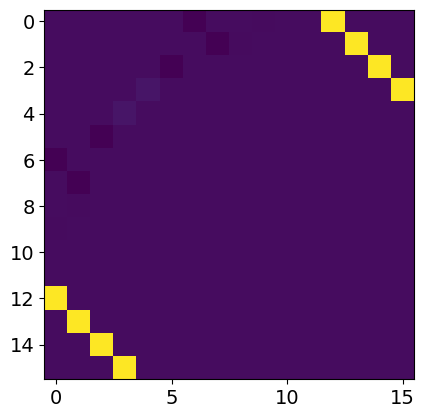

In [26]:
plt.imshow(cpl_172.real[:16, :16])

In [27]:
cpl_eff = (
    U_eff.conj().T @ (eigenvecs.conj().T @ full_dmat @ eigenvecs)[:16, :16] @ U_eff
)
cpl_eff[np.abs(cpl_eff) < 1e-2] = 0

In [28]:
cpl_eff[:4, :16].real

array([[0.01829431, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.01536255, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.57685436, 0.        , 0.        ,
        0.        ],
       [0.        , 0.01829431, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.01536255, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.57685436, 0.        ,
        0.        ],
       [0.        , 0.        , 0.0182943 , 0.        , 0.        ,
        0.01689393, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.57681301,
        0.        ],
       [0.        , 0.        , 0.        , 0.01829431, 0.01282852,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.57691774]])

In [29]:
cpl_172[:4, :16].real

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.01704285,  0.        ,  0.        , -0.00144532,
         0.        ,  0.        ,  0.57685038,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        , -0.01704285, -0.00144532,  0.        ,
         0.        ,  0.        ,  0.        ,  0.57685038,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.01872656,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.5768    ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.01421467,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.57692878]])

In [30]:
J0_idx = np.arange(0, 4)
weights_J0 = np.sum(np.abs(U_eff[J0_idx, :]) ** 2, axis=0)

# similarly for J=1
J1_idx = np.arange(4, 16)
weights_J1 = np.sum(np.abs(U_eff[J1_idx, :]) ** 2, axis=0)

print(weights_J0)
print(weights_J1)

[9.99748926e-01 9.99748926e-01 9.99748926e-01 9.99748926e-01
 1.24147131e-07 2.15299548e-07 1.78036399e-07 1.78036394e-07
 1.27703713e-09 1.27703776e-09 1.17525372e-27 8.02043685e-30
 2.50894992e-04 2.50894992e-04 2.50858900e-04 2.50950123e-04]
[2.51074305e-04 2.51074305e-04 2.51074200e-04 2.51074270e-04
 9.99999876e-01 9.99999785e-01 9.99999822e-01 9.99999822e-01
 9.99999999e-01 9.99999999e-01 1.00000000e+00 1.00000000e+00
 9.99749105e-01 9.99749105e-01 9.99749141e-01 9.99749050e-01]


In [31]:
overlaps = np.abs(np.diag(Psi_uncoupled_eff.conj().T @ U172))
print("min overlap in P-space:", overlaps.min())

min overlap in P-space: 0.999969858880238


In [32]:
overlaps

array([1.        , 1.        , 1.        , 1.        , 0.99997828,
       0.99997613, 0.99997691, 0.99997691, 0.9999811 , 0.9999811 ,
       0.99998116, 0.99998116, 0.99997063, 0.99997063, 0.99996986,
       0.99997201])

In [33]:
Ez = smp.Symbol("Ez", real=True)
Ω0 = smp.Symbol("Ω0")
ω0 = smp.Symbol("ω0", real=True)
δ0 = smp.Symbol("δ0", real=True)
cpl_mu = Hmw0.copy()
cpl_mu[np.abs(cpl_mu) < 1e-2] = 0  # filter small values

heff1 = Heff1.copy()
heff1[np.abs(heff1) < 1e-5] = 0  # filter small values

heff2 = Heff2.copy()
heff2[np.abs(heff2) < 1e-7] = 0

heff0 = smp.Matrix(Heff0.copy())
for idx in range(4, 16):
    heff0[idx, idx] -= ω0
for idx in range(0, 16):
    heff0[idx, idx] -= H0[1, 1]

heff0 = heff0.subs({ω0: H0[13, 13] - H0[1, 1] + δ0})
np.fill_diagonal(cpl_mu, 0)
Heff = smp.Matrix(heff0 + Ez * heff1 + Ez**2 * heff2 + Ω0 * cpl_mu)
func, _ = sympy_matrix_to_julia_fill_hermitian(Heff, "hamiltonian_effective!")

In [34]:
print(func)

function hamiltonian_effective!(H, Ez, Ω0, δ0)
    @inbounds begin
        zero_matrix!(H)
        t0 = Ez .^ 2
        H[1,1] = -0.203910287276813
        H[1,5] = 98.8468961775812 * Ez
        H[5,1] = conj(H[1,5])
        H[1,6] = 4719731.80277188 * Ez - 0.352905590484275 * Ω0
        H[6,1] = conj(H[1,6])
        H[1,7] = 3037.686121584 * Ez
        H[7,1] = conj(H[1,7])
        H[1,8] = 64.8184489245145 * Ez
        H[8,1] = conj(H[1,8])
        H[1,9] = -2827.42366898643 * Ez
        H[9,1] = conj(H[1,9])
        H[1,10] = 165447.844974341 * Ez - 0.0123709295072095 * Ω0
        H[10,1] = conj(H[1,10])
        H[1,11] = -2739903.01558743 * Ez + 0.204869075615216 * Ω0
        H[11,1] = conj(H[1,11])
        H[1,12] = -1554.75150117724 * Ez
        H[12,1] = conj(H[1,12])
        H[1,13] = 5459877.56152657 * Ez - 0.408248073511166 * Ω0
        H[13,1] = conj(H[1,13])
        H[1,14] = -60.8047017236989 * Ez
        H[14,1] = conj(H[1,14])
        H[1,15] = 114.347618969987 * Ez
    

In [35]:
heff0 = smp.Matrix(H0.copy())
for idx in range(4, 16):
    heff0[idx, idx] -= ω0
for idx in range(0, 36):
    heff0[idx, idx] -= H0[1, 1]
heff0 = heff0.subs({ω0: H0[13, 13] - H0[1, 1] + δ0})
stark = eigenvecs.conj().T @ HSz_unc @ eigenvecs
stark[stark < 1e-5] = 0
cpl = full_dmat.copy()
cpl[cpl < 1e-5] = 0
Heff = smp.Matrix(heff0 + stark * Ez + Ω0 * cpl)
func, _ = sympy_matrix_to_julia_fill_hermitian(Heff, "hamiltonian_effective!")


In [36]:
print(func)


function hamiltonian_effective!(H, Ez, Ω0, δ0)
    @inbounds begin
        zero_matrix!(H)
        t0 = 0.577350269189626 * Ω0
        H[1,1] = -0.203910287276813
        H[1,5] = 98.8468961775812 * Ez
        H[5,1] = conj(H[1,5])
        H[1,6] = 4719731.80277188 * Ez
        H[6,1] = conj(H[1,6])
        H[1,7] = 3037.686121584 * Ez
        H[7,1] = conj(H[1,7])
        H[1,8] = 64.8184489245145 * Ez
        H[8,1] = conj(H[1,8])
        H[1,9] = t0
        H[9,1] = conj(H[1,9])
        H[1,10] = 165447.844974341 * Ez
        H[10,1] = conj(H[1,10])
        H[1,13] = 5459877.56152657 * Ez
        H[13,1] = conj(H[1,13])
        H[1,15] = 114.347618969987 * Ez
        H[15,1] = conj(H[1,15])
        H[2,6] = 104.648842317083 * Ez
        H[6,2] = conj(H[2,6])
        H[2,7] = 3.25093675287555 * Ez
        H[7,2] = conj(H[2,7])
        H[2,8] = 0.00141053601389573 * Ez
        H[8,2] = conj(H[2,8])
        H[2,10] = 14.0628229016998 * Ez + t0
        H[10,2] = conj(H[2,10])
        H[

In [37]:
HSz_unc[np.nonzero(HSz_unc)]

array([-7721437.06731616+0.j, -7721437.06731616+0.j,
       -7721437.06731616+0.j, -7721437.06731616+0.j,
       -5980999.43410083+0.j, -5980999.43410083+0.j,
       -5980999.43410083+0.j, -5980999.43410083+0.j,
       -7721437.06731616+0.j, -6906263.26660222+0.j,
       -7721437.06731616+0.j, -6906263.26660222+0.j,
       -7721437.06731616+0.j, -6906263.26660222+0.j,
       -7721437.06731616+0.j, -6906263.26660222+0.j,
       -5980999.43410083+0.j, -5980999.43410083+0.j,
       -5980999.43410083+0.j, -5980999.43410083+0.j,
       -5980999.43410083+0.j, -5980999.43410083+0.j,
       -5980999.43410083+0.j, -5980999.43410083+0.j,
       -6906263.26660222+0.j, -6906263.26660222+0.j,
       -6906263.26660222+0.j, -6906263.26660222+0.j,
       -5980999.43410083+0.j, -5980999.43410083+0.j,
       -5980999.43410083+0.j, -5980999.43410083+0.j])

In [38]:
heff0 = Huncoupled
stark = HSz_unc.copy()
Heff = smp.Matrix(heff0 + stark * Ez)
func, _ = sympy_matrix_to_julia_fill_hermitian(Heff, "hamiltonian_full_nocoupling!")
print(func)

function hamiltonian_full_nocoupling!(H, Ez)
    @inbounds begin
        zero_matrix!(H)
        t0 = -7721437.06731616 * Ez
        t1 = -5980999.43410083 * Ez
        t2 = -6906263.26660222 * Ez
        H[1,1] = -20891.3873116726
        H[1,9] = t0
        H[9,1] = conj(H[1,9])
        H[1,20] = -12045.0481400455
        H[20,1] = conj(H[1,20])
        H[1,22] = 6022.52407002275
        H[22,1] = conj(H[1,22])
        H[1,23] = 6022.52407002275
        H[23,1] = conj(H[1,23])
        H[1,25] = -4917.37031172851
        H[25,1] = conj(H[1,25])
        H[2,2] = 20891.5431975001
        H[2,3] = -41783.1822927442
        H[3,2] = conj(H[2,3])
        H[2,10] = t0
        H[10,2] = conj(H[2,10])
        H[2,24] = -6022.52407002275
        H[24,2] = conj(H[2,24])
        H[2,26] = 4917.37031172851
        H[26,2] = conj(H[2,26])
        H[2,27] = 4917.37031172851
        H[27,2] = conj(H[2,27])
        H[2,29] = -6022.52407002275
        H[29,2] = conj(H[2,29])
        H[3,3] = 20891.639

In [41]:
cpl = full_dmat.copy()
cpl[cpl < 1e-5] = 0
Heff = smp.Matrix(Ω0 * cpl / 2)
func, _ = sympy_matrix_to_julia_fill_hermitian(Heff, "coupling_full!")
print(func)

function coupling_full!(H, Ω0)
    @inbounds begin
        zero_matrix!(H)
        t0 = 0.288675134594813 * Ω0
        H[1,9] = t0
        H[9,1] = conj(H[1,9])
        H[2,10] = t0
        H[10,2] = conj(H[2,10])
        H[3,11] = t0
        H[11,3] = conj(H[3,11])
        H[4,12] = t0
        H[12,4] = conj(H[4,12])
    end
    nothing
end
